In [1]:
min_lon, max_lon, min_lat, max_lat = bbox  = -98.5, -60, 10, 42.5

min_time = "2020-06-01T00:00:00Z"
max_time = "2020-11-17T00:00:00Z"

## Glider

In [2]:
from erddapy import ERDDAP

e = ERDDAP(
    server="https://gliders.ioos.us/erddap",
    protocol="tabledap",
)

kw = {
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "min_time": min_time,
    "max_time": max_time,
    "cdm_data_type": "trajectoryprofile"
}


search_url = e.get_search_url(response="csv", **kw)
print(search_url)

https://gliders.ioos.us/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=tabledap&cdm_data_type=trajectoryprofile&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=(ANY)&variableName=(ANY)&minLon=-98.5&maxLon=-60&minLat=10&maxLat=42.5&minTime=1590969600.0&maxTime=1605571200.0


In [3]:
import pandas as pd


search = pd.read_csv(search_url)
gliders = search["Dataset ID"].values

gliders_list = "\n".join(gliders)
print(f"Found {len(gliders)} Glider Datasets.")

Found 75 Glider Datasets.


In [4]:
from joblib import Parallel, delayed
import multiprocessing


def request_track(dataset_id):
    e.constraints = None
    e.protocol = "tabledap"
    e.variables = ["time", "longitude", "latitude"]
    e.dataset_id = dataset_id
    # Drop units in the first line and NaNs.
    df = e.to_pandas(response="csv", skiprows=(1,)).dropna()
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")
    return (dataset_id, df)


num_cores = multiprocessing.cpu_count()
downloads = Parallel(n_jobs=num_cores)(
    delayed(request_track)(dataset_id) for dataset_id in gliders
)

gliders = {glider: df for (glider, df) in downloads}

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def make_map():
    fig, ax = plt.subplots(
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(9, 9),
    )
    ax.set_extent(bbox)
    ax.coastlines()
    return fig, ax

## Tracks

In [6]:
import os
import sys

import lxml.html

from urllib.request import urlopen, urlretrieve


def url_lister(url):
    urls = []
    connection = urlopen(url)
    dom = lxml.html.fromstring(connection.read())
    for link in dom.xpath("//a/@href"):
        urls.append(link)
    return urls


def download(url, path):
    sys.stdout.write(fname + "\n")
    if not os.path.isfile(path):
        urlretrieve(url, filename=path, reporthook=progress_hook(sys.stdout))
        sys.stdout.write("\n")
        sys.stdout.flush()


def progress_hook(out):
    """
    Return a progress hook function, suitable for passing to
    urllib.retrieve, that writes to the file object *out*.
    """

    def it(n, bs, ts):
        got = n * bs
        if ts < 0:
            outof = ""
        else:
            # On the last block n*bs can exceed ts, so we clamp it
            # to avoid awkward questions.
            got = min(got, ts)
            outof = "/%d [%d%%]" % (ts, 100 * got // ts)
        out.write("\r  %d%s" % (got, outof))
        out.flush()

    return it

In [7]:
nhc = "https://www.nhc.noaa.gov/gis/best_track/"

fnames = [
    fname
    for fname in url_lister(nhc)
    if fname.startswith("al") and "2020_best_track.zip" in fname
]

Find glider and argo data for the 2020 Hurricane season from June 1st to November 10th.

![](https://mail.google.com/mail/u/0?ui=2&ik=e4e81e7a37&attid=0.1&permmsgid=msg-f:1683170726513261809&th=175bd2dba228bcf1&view=fimg&sz=s0-l75-ft&attbid=ANGjdJ_R23YgACSB_jfLvNVn25iAvPcIbAVQcshGo_G_S8JM5iIP8JHGrzU7M6ULyV0-WLHDLaj9Nsvdnr_Flr_Es5bJFTKUsdNxEK4GurAlckY03zYPwBZokQa6HSw&disp=emb&realattid=175bd2301bf82a2e6c31)

In [8]:
import os
from pathlib import Path

path = Path(".").joinpath("data", "hurricane").absolute()

if not path.exists():
    os.makedirs(path)

for fname in fnames:
    url = f"{nhc}/{fname}"
    download(url, path.joinpath(fname))

al012020_best_track.zip
al022020_best_track.zip
al032020_best_track.zip
al042020_best_track.zip
al052020_best_track.zip
al062020_best_track.zip
al072020_best_track.zip
al082020_best_track.zip
al092020_best_track.zip
al102020_best_track.zip
al112020_best_track.zip
al122020_best_track.zip
al132020_best_track.zip
al142020_best_track.zip
al152020_best_track.zip
al162020_best_track.zip
al172020_best_track.zip
al182020_best_track.zip
al192020_best_track.zip
al202020_best_track.zip
al212020_best_track.zip
al222020_best_track.zip
al232020_best_track.zip
al242020_best_track.zip
al252020_best_track.zip
al262020_best_track.zip
al272020_best_track.zip
al282020_best_track.zip
al292020_best_track.zip
al302020_best_track.zip
al312020_best_track.zip


In [9]:
from glob import glob

import geopandas


def create_datetime(df):
    df["HOUR"] = df["HHMM"].str.slice(start=0, stop=2)
    df["MINUTE"] = df["HHMM"].str.slice(start=2)

    cols = ["YEAR", "MONTH", "DAY", "HOUR", "MINUTE"]
    df["time"] = pd.to_datetime(df[cols], format="Y%-M%-D% H%:m%")
    df = df[["time", "LON", "LAT"]]
    df = df.set_index("time")
    return df


def read_ziped(fname, code):
    code = code.upper()
    df = geopandas.read_file(
        f"zip://{fname}/{code}_pts.shp"
    )
    return create_datetime(df)

In [10]:
tracks = {}

for fname in path.glob("*.zip"):
    code = fname.stem.split("_")[0]
    df = read_ziped(fname, code)
    df.index = df.index.tz_localize("UTC")
    df = df[pd.to_datetime(min_time):pd.to_datetime(max_time)]
    if not df.empty:
        tracks.update({code: df})

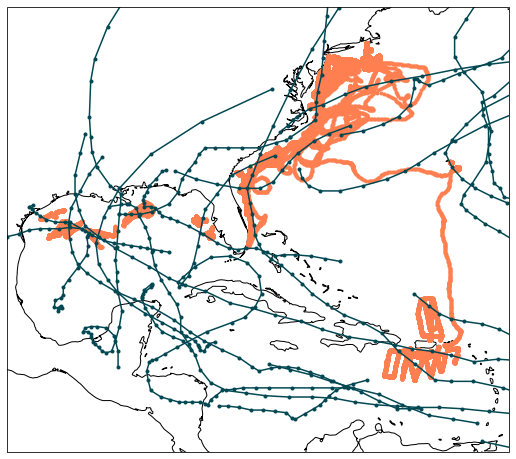

In [11]:
colors = ["#ff7f50", "#004752"]

fig, ax = make_map()


for glider, df in gliders.items():
    df = df.dropna()
    ax.plot(df["longitude"], df["latitude"], color=colors[0], linestyle="none", marker=".")
for track, df in tracks.items():
    df = df.dropna()
    ax.plot(df["LON"], df["LAT"], color=colors[1], linestyle="-", marker=".")

Find glider and argo data for the 2020 Hurricane season from June 1st to November 10th.

![](https://mail.google.com/mail/u/0?ui=2&ik=e4e81e7a37&attid=0.1&permmsgid=msg-f:1683170726513261809&th=175bd2dba228bcf1&view=fimg&sz=s0-l75-ft&attbid=ANGjdJ_R23YgACSB_jfLvNVn25iAvPcIbAVQcshGo_G_S8JM5iIP8JHGrzU7M6ULyV0-WLHDLaj9Nsvdnr_Flr_Es5bJFTKUsdNxEK4GurAlckY03zYPwBZokQa6HSw&disp=emb&realattid=175bd2301bf82a2e6c31)

In [12]:
# We will interpolate all data to 6 hours interval
# glider data is approximately a few minutes while track data is every 6 hours
new_index = pd.date_range(min_time, max_time, freq="6h")


def reindex_and_interpolate(df, new_index):
    return df.reindex(df.index | new_index).interpolate(method='index', limit_direction='both').loc[new_index]


inter_gliders = {}
for glider, df in gliders.items():
    df = reindex_and_interpolate(df, new_index)
    inter_gliders.update({glider: df})

inter_tracks = {}
for track, df in tracks.items():
    df = reindex_and_interpolate(df, new_index)
    inter_tracks.update({track: df})

In [13]:
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap


fig, ax = make_map()

title = ax.text(
    0.5, 1.05, "",
    bbox={"facecolor": "w", "alpha":0.5, "pad":5},
    transform=ax.transAxes, ha="center"
)

lines = []
intensity = []
x_point, y_point = [], []

for track in inter_tracks.keys():
    line, = ax.plot([], [], color=colors[1], marker=".", linestyle="-")
    lines.append(line)
    

r, g, b = 1, 0.49803922, 0.31372549
alphas = [
    [r, g, b, 0],
    [r, g, b, 0.5],
    [r, g, b, 1]
]
cmap = LinearSegmentedColormap.from_list("", alphas)
scatter = ax.scatter(x_point, y_point, s=50, c=[], cmap=cmap, vmin=0,vmax=1)


def init():
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    for line in lines:
        line.set_data([],[])
    return title, # scatter


def update_glider(k):
    global scatter, intensity
    x, y = [], []
    for glider, df in inter_gliders.items():
        try:
            df = df.dropna()
            point = df.iloc[k]
            x.append(point["longitude"])
            y.append(point["latitude"])
        except IndexError:
            # Some gliders are shorter
            pass
    x_point.extend(x)
    y_point.extend(y)
    arr = np.c_[x_point, y_point]
    scatter.set_offsets(arr)
    #calculate new color values
    intensity = np.concatenate((np.array(intensity)*0.80, np.ones(len(x))))
    scatter.set_array(intensity)
    return scatter,


def update_hurricane(k):
    x_lines, y_lines = [], []
    for track, df in inter_tracks.items():
        try:
            df = df.dropna()
            point = df.iloc[:k]
            x_lines.extend([point["LON"].squeeze().tolist()])
            y_lines.extend([point["LAT"].squeeze().tolist()])
        except IndexError:
            # Some tracks are shorter
            pass
    for idx, line in enumerate(lines):
        line.set_data(x_lines[idx], y_lines[idx])
    return lines,

def update(k):
    update_glider(k)
    update_hurricane(k)
    title.set_text(new_index[k])
    return title,


anim = FuncAnimation(fig, update, init_func=init, frames=len(new_index), blit=True);
plt.close()  # remove the extra frame output.

In [14]:
# We cannot use this b/c the animation is too big
# html = HTML(anim.to_jshtml())
# display(html)

In [15]:
HTML(anim.to_html5_video())